In [ ]:
import torch
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import csv
import torch.nn as nn
import matplotlib.pyplot as plt
from torchsummary import summary
from torch import optim
from torch.utils.data import TensorDataset
from IPython.display import clear_output
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.transforms.v2 import Compose, ToDtype, Normalize, RandomAutocontrast, Resize, Resize
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
def create_class_dict(csv_path):
    class_dict = {}
    with open(csv_path, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            class_dict[int(row['id'])] = row['category']
    return class_dict

class_dict = create_class_dict("human_poses_data/activity_categories.csv")

In [4]:
def load_images_from_folder(folder, target_size=(128,128)):
    images=[]
    img_ids=[]
    for filename in sorted(os.listdir(folder),key=lambda x: int(x.split(".")[0])):
        idx = filename.split(".")[0]
        img_ids.append(idx)

        img_path = os.path.join(folder,filename)
        img  = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,target_size) 
        img = img / 255.0
        images.append(img)

    return np.array(images),img_ids

X_train, img_ids = load_images_from_folder("human_poses_data/img_train")

In [5]:
df = pd.read_csv("human_poses_data/train_answers.csv", sep=",")
df["img_id"] = df["img_id"].astype(str)

id_to_label = dict(zip(df["img_id"], df["target_feature"]))

le = LabelEncoder()

y_train = le.fit_transform(np.array([id_to_label[img_id] for img_id in img_ids]))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (12367, 128, 128, 3)
y_train shape: (12367,)


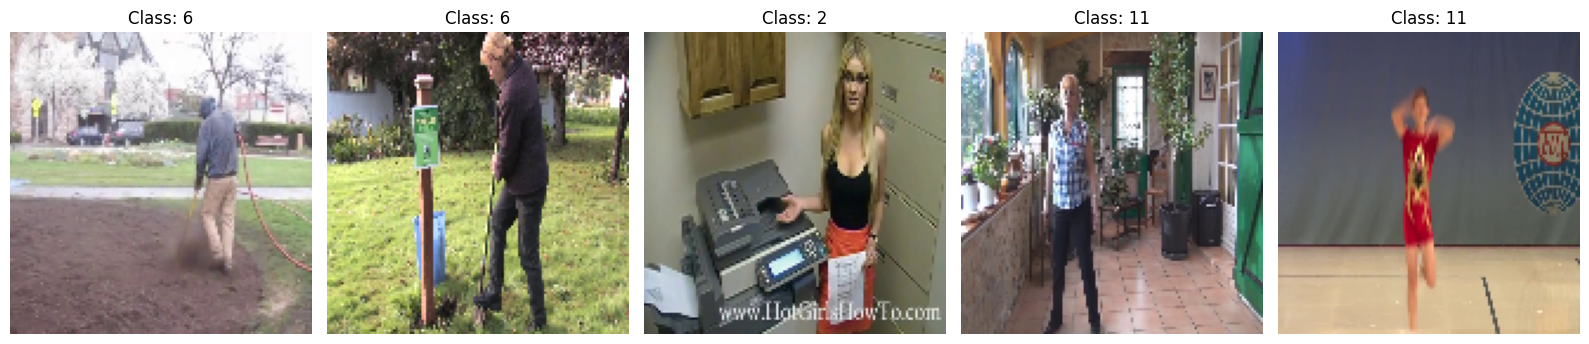

In [6]:
def showImages(count_size):
    plt.figure(figsize=(16, 16))
    
    for i in range(count_size):
        random_idx = np.random.randint(0, X_train.shape[0])
        
        plt.subplot(1, count_size, i+1)
        plt.imshow(X_train[random_idx])
        plt.title(f"Class: {y_train[random_idx]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

showImages(5)

In [7]:
IMAGE_LENGTH = X_train[0].shape
IMAGE_LENGTH

(128, 128, 3)

In [8]:
X_train_tensor = torch.from_numpy(X_train.transpose(0, 3, 1, 2)).float()
y_train_tensor = torch.from_numpy(y_train).long() 

transforms = Compose([
    Resize((64, 64)),
    ToDtype(torch.float32, scale=True),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    RandomAutocontrast(p=1.0),
])

# transform = Compose([
#     Resize((224, 224)),
#     PILToTensor(),
#     ToDtype(torch.float32, scale=True),
#     Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
# ])

class CustomDataset(TensorDataset):
    def __getitem__(self, index):
        x, y = super().__getitem__(index)
        return transforms(x), y

data = CustomDataset(X_train_tensor, y_train_tensor)

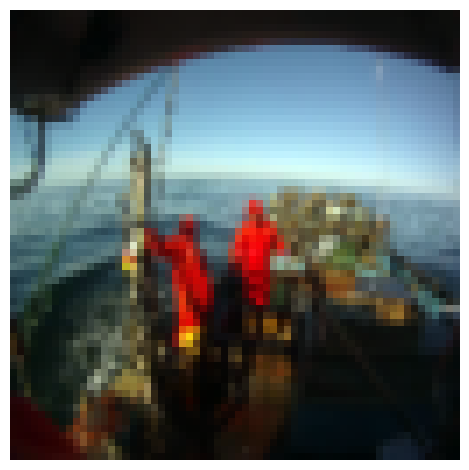

In [17]:
plt.subplot(1, 1, 1)
plt.imshow(data[23][0].permute(1, 2, 0))
plt.axis('off')
plt.tight_layout()
plt.show()

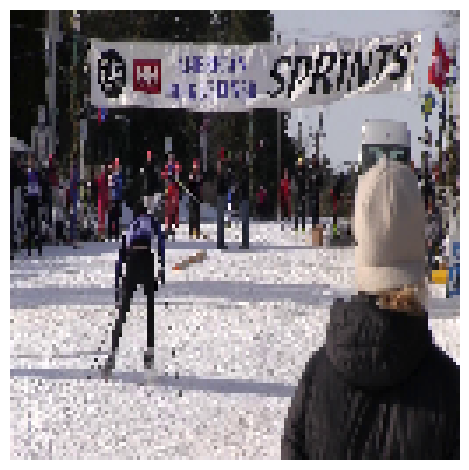

In [18]:
plt.subplot(1, 1, 1)
plt.imshow(data[10][0].permute(1, 2, 0))
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# def show_losses(train_loss, test_loss):
#     clear_output()

#     plt.figure(figsize=(16,8))

#     plt.plot(np.arange(len(train_loss)), np.array(train_loss),color="b",label="Тренировочная выборка")
#     plt.grid()

#     plt.plot(np.arange(len(test_loss)), np.array(test_loss),color="r",label="Тестовая выборка")
#     plt.title("Loss values")
#     plt.grid()

#     plt.legend()

#     plt.show()

In [ ]:
def show_losses(train, val, acc, f1):
    clear_output()
    plt.figure(figsize=(12,4))

    PAST_EPOCHS = len(train)
    
    plt.subplot(1, 3, 1)
    plt.title("Loss values")
    plt.plot(np.arange(PAST_EPOCHS), train, color="b", label=f'Train Loss = {train[-1]}')
    plt.plot(np.arange(PAST_EPOCHS), val, color="orange", label=f'Val Loss = {val[-1]}')
    plt.yscale('log')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.title("Accuracy")
    plt.plot(np.arange(PAST_EPOCHS), acc, color="b", label=f'Acuracy = {acc[-1]}')
    # plt.yscale('log')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.title("F1 score")
    plt.plot(np.arange(PAST_EPOCHS), f1, color="b", label=f'F1 = {f1[-1]}')
    # plt.yscale('log')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.tight_layout()
    plt.show()

In [ ]:
def run_epoch(model, dataloader, loss_function, optimizer=None):
    
    model.train() if optimizer is not None else model.eval()

    total_loss = 0
    with torch.set_grad_enabled(optimizer is not None):
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            loss = loss_function(pred, y)

            total_loss += loss.item()

            if optimizer != None:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

    return total_loss / len(dataloader)

In [ ]:
def predict(model, dataloader):
    y_true, y_pred = [], []

    model.eval()
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to('cpu')
            
            y_true += list(y)
            y_pred += list(torch.argmax(model(X), dim=1).cpu())
    return y_true, y_pred 

In [ ]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # (32, 128, 128)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (32, 64, 64)
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (64, 64, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (64, 32, 32)
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (128, 32, 32)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (128, 16, 16)
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # (256, 16, 16)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (256, 8, 8)

            nn.Conv2d(256, 400, kernel_size=3, stride=1, padding=1),  # (256, 8, 8)
            nn.BatchNorm2d(400),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (400, 4, 4)

            nn.Conv2d(400, 512, kernel_size=3, stride=1, padding=0),  # (512, 2, 2)
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 16)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

In [32]:
model = Model1().to(device)
summary(model, input_size=(3, 128, 128))

NUM_EPOCHS = 50

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         295,168
      BatchNorm2d-14          [-1, 256,

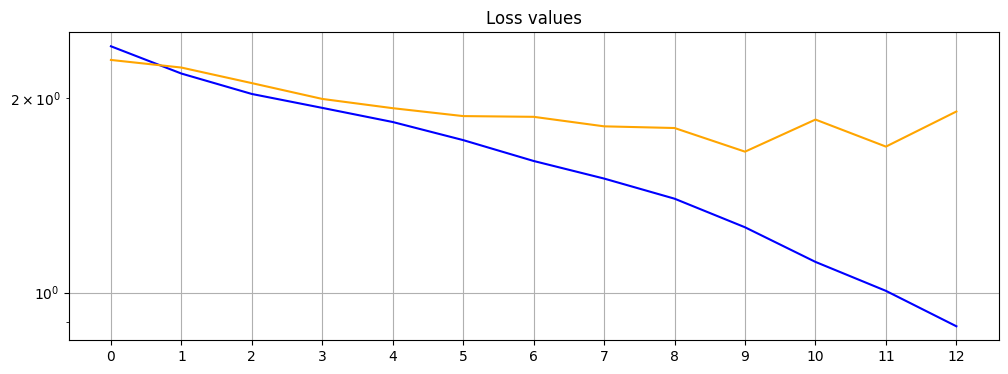

  3%|▎         | 2/73 [00:05<03:24,  2.88s/it]


KeyboardInterrupt: 

In [ ]:
#  Подготовка данных
X_train_tensor = torch.from_numpy(X_train.transpose(0, 3, 1, 2)).float()
y_train_tensor = torch.from_numpy(y_train).long() 

# transforms = Compose([
#     ToDtype(torch.float32, scale=True),
#     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     RandomAutocontrast(p=1.0),  # Увеличивает контраст (p=1.0 — всегда применяется)
# ])

# class CustomDataset(TensorDataset):
#     def __getitem__(self, index):
#         x, y = super().__getitem__(index)
#         return transforms(x), y

# data = CustomDataset(X_train_tensor, y_train_tensor)

data = TensorDataset(X_train_tensor, y_train_tensor)


train_size = int(0.75 * len(data))
val_size = len(data) - train_size
dataset_train, dataset_val = random_split(data, [train_size, val_size])

BATCH_SIZE = 128
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)

batch_images, batch_labels = next(iter(train_loader))
print(f"Размер батча изображений: {batch_images.shape}")
print(f"Размер батча меток: {batch_labels.shape}")


#  Обучение модели
model = Model1().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 
                           lr=0.001,
                           weight_decay=1e-5)


train_loss_hist = []
test_loss_hist = []
for i in range(NUM_EPOCHS):

    train_loss = run_epoch(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)
    test_loss = run_epoch(model, val_loader, loss_function)
    test_loss_hist.append(test_loss)

    show_losses(train_loss_hist, test_loss_hist)

print(f"Min loss: {min(test_loss_hist)}")

In [36]:
print(f"Min loss: {min(test_loss_hist)}")

Min loss: 1.6513731145858765


In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred, y_true = predict(model, val_loader)

print(y_pred[:10])
print(y_true[:10])

print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'Precision: {precision_score(y_true, y_pred, average="macro")}')
print(f'Recall: {recall_score(y_true, y_pred, average="macro")}')
print(f'F1: {f1_score(y_true, y_pred, average="macro")}')
print(f"Min Loss: {min(test_loss_hist)}")

100%|██████████| 25/25 [00:07<00:00,  3.50it/s]


[tensor(14), tensor(15), tensor(8), tensor(0), tensor(3), tensor(5), tensor(3), tensor(8), tensor(5), tensor(0)]
[tensor(3), tensor(15), tensor(8), tensor(9), tensor(3), tensor(5), tensor(3), tensor(11), tensor(5), tensor(0)]
Accuracy: 0.48803363518758086


z:\projects\Yandex Kaggle\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.4824182205360117
Recall: 0.38614817967054355
F1: 0.4017458579019941
Min Loss: 1.6513731145858765


In [38]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # (32, 128, 128)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (32, 64, 64)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (64, 64, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (64, 32, 32)
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (128, 32, 32)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (128, 16, 16)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # (256, 16, 16)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (256, 8, 8)

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),  # (384, 8, 8)
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (384, 4, 4)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=3, stride=1, padding=1),  # (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (512, 2, 2)

            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),  # (1024, 2, 2)
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (1024, 1, 1)
        )



        self.skip1 = nn.Sequential(  # (32, 64, 64)
            nn.Conv2d(32, 128, kernel_size=3, stride=2, padding=1),  # (128, 64, 64)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 16, 16)
        )
        
        self.skip2 = nn.Sequential(  # (384, 4, 4)
            nn.Conv2d(384, 1024, kernel_size=3, stride=2, padding=1),  # (1024, 2, 2)
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (1024, 1, 1)
        )


        self.classifier = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 16)
        )

    def forward(self, x):
        x = self.block1(x)
        skip = self.skip1(x)
        out = self.block2(x)

        x = self.block3(skip + out)
        skip = self.skip2(x)
        out = self.block4(x)

        x = skip + out
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

In [16]:
model = Model2().to(device)
summary(model, input_size=(3, 128, 128))

NUM_EPOCHS = 50

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5          [-1, 128, 32, 32]          36,992
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
         MaxPool2d-8          [-1, 128, 16, 16]               0
            Conv2d-9           [-1, 64, 64, 64]          18,496
      BatchNorm2d-10           [-1, 64, 64, 64]             128
             ReLU-11           [-1, 64, 64, 64]               0
        MaxPool2d-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]          73,856
      BatchNorm2d-14          [-1, 128,

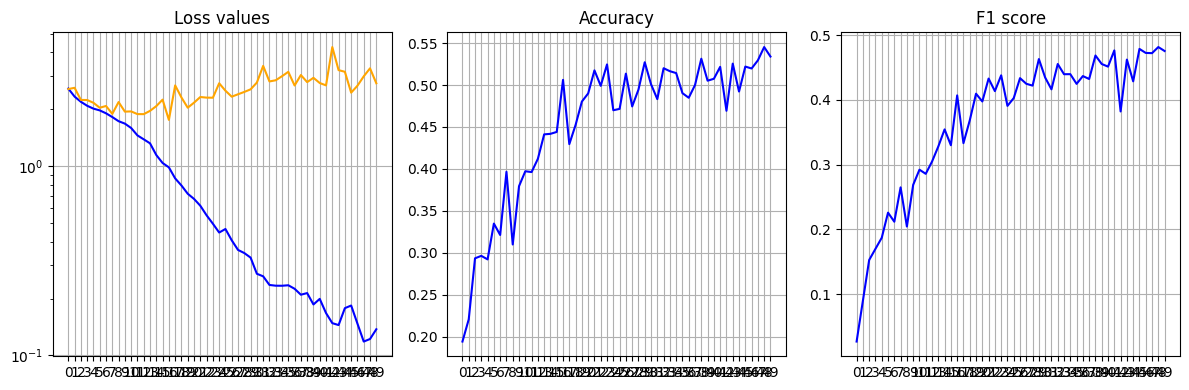

Min loss: 1.7602464532852173
Max Accuracy: 0.5452781371280725
Max F1: 0.48178357138112243


In [46]:
from sklearn.metrics import accuracy_score, f1_score

#  Подготовка данных
X_train_tensor = torch.from_numpy(X_train.transpose(0, 3, 1, 2)).float()
y_train_tensor = torch.from_numpy(y_train).long() 

transforms = Compose([
    ToDtype(torch.float32, scale=True),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    RandomAutocontrast(p=1.0),
])

class CustomDataset(TensorDataset):
    def __getitem__(self, index):
        x, y = super().__getitem__(index)
        return transforms(x), y

data = CustomDataset(X_train_tensor, y_train_tensor)

# data = TensorDataset(X_train_tensor, y_train_tensor)


train_size = int(0.75 * len(data))
val_size = len(data) - train_size
dataset_train, dataset_val = random_split(data, [train_size, val_size])

BATCH_SIZE = 128
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)

batch_images, batch_labels = next(iter(train_loader))
# print(f"Размер батча изображений: {batch_images.shape}")
# print(f"Размер батча меток: {batch_labels.shape}")


#  Обучение модели
model = Model2().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 
                           lr=0.001,
                           weight_decay=1e-5)


train_loss_hist = []
test_loss_hist = []
accuracy = []
f1 = []

for i in range(NUM_EPOCHS):

    train_loss = run_epoch(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)

    test_loss = run_epoch(model, val_loader, loss_function)
    test_loss_hist.append(test_loss)

    y_true, y_pred = predict(model, val_loader)
    accuracy.append(accuracy_score(y_true, y_pred))
    f1.append(f1_score(y_true, y_pred, average="macro"))

    if f1[-1] == max(f1):
        torch.save(model, 'model2_best_model.pth')
        torch.save(model.state_dict(), 'model2_best_weights.pth')

    show_losses(train_loss_hist, test_loss_hist, accuracy, f1)


    

print(f"Min loss: {min(test_loss_hist):6>}")
print(f"Max Accuracy: {max(accuracy)}")
print(f"Max F1: {max(f1)}")

In [9]:
model = torch.load('model2_best_model_0.48178357.pth', weights_only=False)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 
                           lr=0.001,
                           weight_decay=1e-5)
optimizer.load_state_dict(model['optimizer_state_dict'])

AttributeError: Can't get attribute 'Model2' on <module '__main__'>

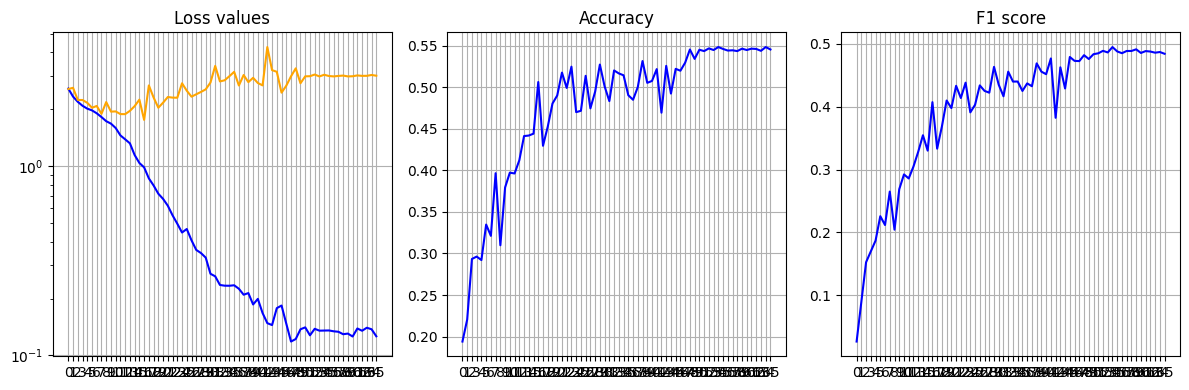

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
for i in range(2 * NUM_EPOCHS):

    train_loss = run_epoch(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)

    test_loss = run_epoch(model, val_loader, loss_function)
    test_loss_hist.append(test_loss)

    y_true, y_pred = predict(model, val_loader)
    accuracy.append(accuracy_score(y_true, y_pred))
    f1.append(f1_score(y_true, y_pred, average="macro"))

    if f1[-1] == max(f1):
        torch.save(model, 'model2_best_model.pth')
        torch.save(model.state_dict(), 'model2_best_weights.pth')

    show_losses(train_loss_hist, test_loss_hist, accuracy, f1)


    

print(f"Min loss: {min(test_loss_hist):6>}")
print(f"Max Accuracy: {max(accuracy)}")
print(f"Max F1: {max(f1)}")

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred, y_true = predict(model, val_loader)

print(y_pred[:10])
print(y_true[:10])

print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'Precision: {precision_score(y_true, y_pred, average="macro")}')
print(f'Recall: {recall_score(y_true, y_pred, average="macro")}')
print(f'F1: {f1_score(y_true, y_pred, average="macro")}')
print(f"Min Loss: {min(test_loss_hist)}")

100%|██████████| 25/25 [00:08<00:00,  3.08it/s]


[tensor(8), tensor(0), tensor(4), tensor(0), tensor(0), tensor(8), tensor(0), tensor(0), tensor(3), tensor(5)]
[tensor(8), tensor(0), tensor(4), tensor(6), tensor(0), tensor(0), tensor(0), tensor(0), tensor(3), tensor(14)]
Accuracy: 0.5452781371280725
Precision: 0.47017529548692916
Recall: 0.5157243082928398
F1: 0.48178357138112243
Min Loss: 1.7602464532852173


In [ ]:
torch.save(model, 'model2.pth')

In [ ]:
# Загрузка
model = torch.load('model2.pth')

In [ ]:
torch.save(model.state_dict(), 'weights.pth')

In [ ]:

# Загрузка
model = Model2()  # Сначала создаем экземпляр модели
model.load_state_dict(torch.load('weights.pth'))